In [50]:
import os.path
import sys

import os

# Récupère le chemin d'accès parent de sys.path[0]
parent_dir = os.path.dirname(sys.path[0])

sys.path.append(os.path.abspath(parent_dir))
import importlib
import algorithmes
importlib.reload(algorithmes)
from algorithmes import *
import random
import mesa

## L'implimentation d'un systeme multi agent qui suit le Protocole AMI

## Création des Agents

In [51]:
class Recuit_sem(mesa.Agent):
    
    # Création d'agent Recuit simulé 


    def __init__(self, model,parameters):
        
        super().__init__(self,model)
        self.parameters = parameters
        self.history = []

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Recuit simulé
        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _  = recuit_simule(self.model.Pool[solution_index],self.parameters['temperature_initiale'] , self.parameters['temperature_finale'],alpha=0.99)
        self.model.Pool[solution_index] = new_solution

            
    def step(self):
        
        self.execute()

In [52]:
class Tabou(mesa.Agent):
    
    # Création d'agent Tabou 

    def __init__(self,  model,parameters):
        super().__init__(self,model)
      
        self.parameters = parameters
        self.history = []
        self.initial_solution = None

    def execute(self):

        # Tirer une solution aléatoire du Pool et la remplacer par une solution améliorer par Tabou
        solution_index = np.random.randint(len(self.model.Pool))
        new_solution, meilleure_valeur , _ = tabou(self.model.Pool[solution_index] ,self.parameters['taille_tabou'],self.parameters['max_iterations'],self.parameters['n_voisin'])
        self.model.Pool[solution_index] = new_solution

            
    def step(self):
        self.execute()

In [53]:
class Genetic(mesa.Agent):
    
    # Création d'agent genetique 


    def __init__(self,  model,parameters):

        super().__init__(self,model)
        self.parameters = parameters


    def execute(self):

        # Prendre le Pool comme une population initial et la remplacer par une population améliorer par l'algo genetique
        new_solution, meilleure_valeur , _ ,population = genetique(self.model.Pool,self.parameters['taux_mutation'],self.parameters['max_iterations'])
        self.model.Pool = copy.deepcopy(population)

            
    def step(self):
        self.execute()

In [55]:
def compute_Pool_avg(model):
    
    # Calculer le cout moyenne des solutions dans le Pool
    couts = [cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))]
    return sum(couts)/len(couts)

def compute_Pool_min(model):
    
    # Calculer le cout minimum des solution dans le Pool
    couts = [cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))]

    return min(couts)

def get_the_best_solution(model):

    # Récupérer la meilleur solution dans le Pool
    couts = np.array([cout(get_route_version2(model.Pool[i], time_window, Q)) for i in range(len(model.Pool))])

    return model.Pool[np.argmin(couts)]

In [74]:
## Les paramètres des Algorithmes 
num_clients = 50
parameters = {'rs' : {'temperature_initiale' : 1  , 'temperature_finale' : 1e-6 } , 'tabou' : {'taille_tabou' : num_clients , 'max_iterations' : 100 , 'n_voisin' : 2} , 'genetic'  : {'taux_mutation' : 0.5 ,'max_iterations' : 10 }}

In [58]:
class SMA(mesa.Model):
    
    """Création d'environnement de communication entre les agents"""


    def __init__(self,Pool,parameters):
        
        self.schedule = mesa.time.RandomActivation(self)
        self.Pool = Pool
        

        # Instanciation des agents 
        self.optimazers = [Recuit_sem(self,parameters['rs']),Tabou(self,parameters['tabou'])]
        self.genetique_optimizer = Genetic(self,parameters['genetic'])

        for agent in self.optimazers : 
            self.schedule.add(agent)

        ## Récuperer à chaque step la meilleur solution dans le Pool et son cout
        self.datacollector = mesa.DataCollector(
            model_reporters={"pool_avg": compute_Pool_avg ,"best_pool": get_the_best_solution,"pool_min": compute_Pool_min } )


    def step(self):

        self.datacollector.collect(self)
        self.schedule.step()


In [59]:
## Création du Pool
Pool = []
list_client_initial = [i for i in range(num_clients)]
for j in range(10): 
    x  = copy.deepcopy(list_client_initial)
    random.shuffle(x)
    Pool.append(x)

In [66]:
sma_env = SMA(Pool,parameters)

In [67]:
for i in range(100):

    # Amélioration de chaque solution par les algo Tabou / Récuit simuler
    sma_env.step()

    if i%10 == 1 :
        
        # Amélioration du Pool par l'algo genetique
        sma_env.genetique_optimizer.execute()
        sma_env.datacollector.collect(sma_env)
    

In [68]:
agent_wealth = sma_env.datacollector.get_model_vars_dataframe()

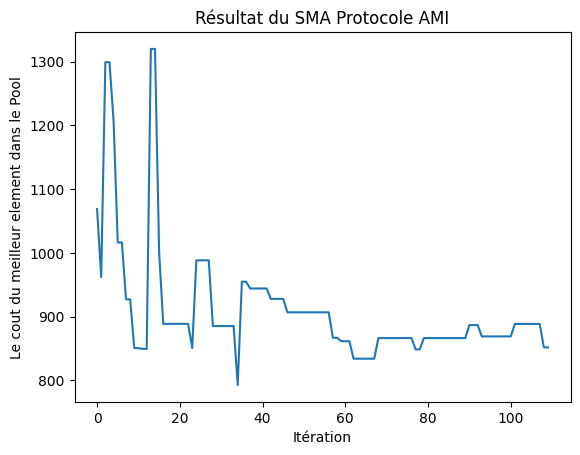

In [75]:
plt.plot(agent_wealth['pool_min'])
plt.title("Résultat du SMA Protocole AMI")
plt.xlabel("Itération")
plt.ylabel("Le cout du meilleur element dans le Pool")
plt.savefig('Résultat_sma_ami1')

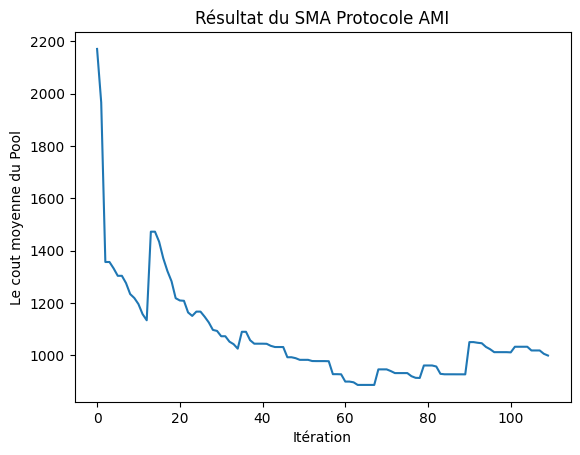

In [76]:
plt.plot(agent_wealth['pool_avg'])
plt.title("Résultat du SMA Protocole AMI")
plt.xlabel("Itération")
plt.ylabel("Le cout moyenne du Pool")
plt.savefig('Résultat_sma_ami2')